# import

In [1]:
import json
import os
import pandas as pd
from basic.slave.slave import *
from tqdm import tqdm

# Parameters

In [2]:
config_info = {
    "index": {
        "irank": {
            "offset": 0.85,
            "long_window": 9,
            "short_window": 6,
            "sigma": 6,
            "v_window": 6,
            "unused_symbols": ['BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'XRPUSDT', 'DOGEUSDT']
        }
    },
    "main": {
        "loss_p": -0.05,
        "profit_p": 0.15,
        "qv_thre": 1200E3,
        "regre": 0.0001,  # 0.005"
        "_alarm": {
            "clear": ['12:00'],
            "orders": ['23:00']
        },
        "_timer": {
            "orders": 60,
            "positions": 1
        },
    },
    "trade": {
        "amountusd": 10000,
        "apikey": "xxxxx",
        "apisets": {
            "bbo": "QUEUE",
            "count_cancel": 5,
            "iceberg": 10000,
            "offer_step": 1,
            "retry": 1,
            "timeInForce": "GTC"
        },
        "hold_time": 240,
        "leverage": 2,
        "orders_type": "BBO",
        "position_type": "BBO",
        "stop_iceberg": 10000,
        "stop_interval": 0.1,
    }
}

# Read

In [3]:
def get_raw_data(path):
    base_url = path['filepath']
    path1 = f"/{path['symbol']}/{path['interval']}"
    url = base_url + path1
    filelist = os.listdir(url)
    filelist.sort()
    filelist_get = [item for item in filelist if
                    path['start_date'] <= item[len(path['symbol']) + 4:len(path['symbol']) + 14] <= path[
                        'end_date']]
    df = pd.DataFrame()
    for file in tqdm(filelist_get):
        df0 = pd.read_csv(fr'{url}/{file}')
        df = pd.concat([df, df0])
    return df.copy()

In [4]:
path_params = {
    'filepath': 'Z:\\um\daily\klines',
    'symbol': 'ETHUSDT',
    'start_date': '2025-05-01',
    'end_date': '2025-08-23',
    'interval': '1m',
}
df = get_raw_data(path_params)
df_klines = df[['open_time', 'open', 'high', 'low', 'close', 'volume', 'quote_volume']].copy()
df_klines.columns = ['t', 'o', 'h', 'l', 'c', 'v', 'qv']
df_klines['t'] = df_klines['t'] + 60000
df_klines.set_index('t', inplace=True)

100%|██████████| 115/115 [00:03<00:00, 36.93it/s]


# index

In [5]:
class IRANK():

    def __init__(self, paras, algoid):
        self.paras = paras
        self.algoid = algoid
        self.df_klines = None
        self.slip_time = 1
        # self.pre_time = 0
        self.calculate()

    def update(self, idx):
        target_prod = []
        if self.slip_time == 1:
            self.slip_time -= 1
            return target_prod

        if df_klines[f'alma_{self.paras["short_window"]}'].loc[idx] > \
                df_klines[f'alma_{self.paras["long_window"]}'].loc[idx] and  \
                df_klines[f'alma_{self.paras["short_window"]}'].loc[idx - 60000] < \
                df_klines[f'alma_{self.paras["long_window"]}'].loc[idx - 60000] and df_klines['price_volatility'].loc[
            idx] > 0.5 and df_klines["rsi"].loc[idx] < 30:
            target_prod.append({'symbol': 'c', 'side': 'BUY'})

        elif df_klines[f'alma_{self.paras["short_window"]}'].loc[idx] < \
                df_klines[f'alma_{self.paras["long_window"]}'].loc[idx] and \
                df_klines[f'alma_{self.paras["short_window"]}'].loc[idx - 60000] > \
                df_klines[f'alma_{self.paras["long_window"]}'].loc[idx - 60000] and df_klines['price_volatility'].loc[
            idx] > 0.5 and df_klines["rsi"].loc[idx] > 70:
            target_prod.append({'symbol': 'c', 'side': 'SELL'})

        return target_prod

    def calculate(self):

        def calculate_alma(df, window=9, sigma=6, offset=0.85):
            m = int(offset * (window - 1))
            s = window / sigma

            # 计算权重
            weights = np.exp(-(np.arange(window) - m) ** 2 / (2 * s ** 2))
            weights /= np.sum(weights)

            # 计算ALMA
            alma = np.convolve(df['c'], weights, mode='valid')

            # 前面补NaN，使长度与原数据一致
            alma = np.concatenate([np.full(window - 1, np.nan), alma])

            return alma

        def calculate_rsi(df, window=14):
            """计算相对强弱指数(RSI)"""
            delta = df['c'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

            rs = gain / loss
            rsi = 100 - (100 / (1 + rs))

            return rsi

        df_klines[f'alma_{self.paras["long_window"]}'] = calculate_alma(df_klines, window=self.paras['long_window'])
        df_klines[f'alma_{self.paras["short_window"]}'] = calculate_alma(df_klines, window=self.paras['short_window'])
        df_klines['rsi'] = calculate_rsi(df_klines)
        df_klines['volume_mean'] = df_klines['v'].rolling(self.paras["v_window"]).mean()
        # 计算价格波动百分比（过滤窄幅波动）
        df_klines['price_volatility'] = (df_klines['c'].pct_change().rolling(10).std() * 100)
        self.df_klines = df_klines.dropna()

In [6]:
irank = IRANK(config_info['index']['irank'], algoid='rank0')

# Algo

In [7]:
class MAIN(SLAVE):

    def __init__(self):
        algoid, config, client, index = None, config_info, None, None
        self.config = config['main']
        self.irank = irank
        super().__init__(client=client, paras=config['trade'], algoid=algoid)

    def x_orders(self):
        # global lock
        target_prod = self.irank.update(HELPER.last_ticker_time())
        if len(target_prod) == 0 or self.infos['total_positions'] != 0:
            return
        # lock = True
        self.slave_orders(target_prod)

    def x_positions(self):
        # global lock

        if self.infos['total_abs_positions'] == 0:
            return 1
        action_info = {}
        for groupid in self.infos['groups']:
            the_trade = self.infos['trades'][(groupid, list(self.infos['groups'][groupid])[0])]
            if self.infos['profits'][groupid] < self.config['loss_p'] * self.infos['abs_originals'][groupid]:
                action_info[groupid] = 'stop'
            elif self.infos['profits'][groupid] > self.config['profit_p'] * self.infos['abs_originals'][groupid]:
                action_info[groupid] = 'take_profit'

        if not action_info:
            return 0
        # lock = False
        self.slave_positions(action_info)
        return 0

    def x_clear(self):
        self.base_clear()

In [8]:
main = MAIN()

In [9]:

def job(day):
    result = []

    for idx in tqdm(day):
        HELPER.update(idx, df_klines)
        main.base_infos()
        if main.x_positions():

            result_cur = HELPER.profit(infos=main.infos, method='group')

            if result_cur is not None:
                result += result_cur
                main.x_clear()

        main.base_infos()
        main.x_orders()

    main.base_infos()
    return result

In [10]:
result = HELPER.driver(df=df_klines, job=job, n_jobs=1, clear=config_info['main']['_alarm']['clear'][0],
                       start='2025-01-01', end='2025-08-24')

100%|██████████| 165600/165600 [00:41<00:00, 3958.03it/s]


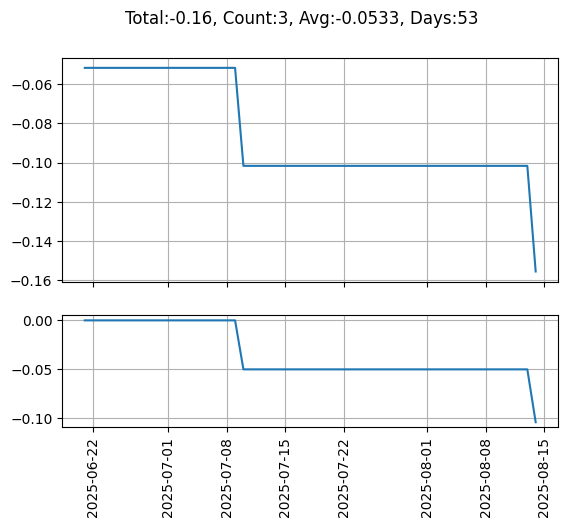

In [11]:
fig, axes, arr = PLOT.profit(result=result, amountusd=config_info['trade']['amountusd'], freq='D')